In [1]:
from __future__ import print_function
from __future__ import division

import pdb
import sys
import os
import numpy as np
import scipy.optimize as opt
import scipy.io as sio
import scipy.special as spf
import yaml

## import diffrantion integral solver from Optics folder
work_dir = os.getcwd()
date_dir = os.path.split(work_dir)[0]
optics_folder = os.path.join(date_dir, 'Optics')
sys.path.append(optics_folder)
import diffraction_int as diffi
import fibonacci as fib

## Import field functions
field_module_folder = os.path.join(date_dir, 'field_functions')             
sys.path.append(field_module_folder)
import far_fields as fi

## Read parameter file to obtain fields
stream = open('param.yaml','r')
parameters = yaml.load(stream)


## plotting stuff
import matplotlib.pyplot as plt
% matplotlib inline


## colorbar stuff 
from mpl_toolkits import axes_grid1

import eqm_slns as osc

## analytic image functions
# import analytic_intensity_functions_xyz as imf

## dipole moments as functions of separation, not pulled from param file
import p_of_d as pod

# pretty fitting
# import lmfit as lf

import anal_foc_diff_fields as afi


## Import physical constants
full_path_to_constant_yaml = os.path.join(date_dir,'physical_constants.yaml')
opened_constant_file = open(full_path_to_constant_yaml,'r')
constants = yaml.load(opened_constant_file)
e = constants['physical_constants']['e']
c = constants['physical_constants']['c']  # charge of electron in statcoloumbs
hbar =constants['physical_constants']['hbar']
nm = constants['physical_constants']['nm']
n_a = constants['physical_constants']['nA']   # Avogadro's number
# Z_o = 376.7303 # impedence of free space in ohms (SI)

## System background
n_b = parameters['general']['background_ref_index']
eps_b = n_b**2.

a = parameters['plasmon']['radius']
#######################################################################
## simulated image 
sensor_size = 2000*nm
# height = 2*mm  # also defines objective lens focal length 
height = 2e6*nm
resolution = 100  # image grid resolution

norm_style = 'per fig'  # 'per fig' or 'across figs'

show_or_save = 'show'
# show_or_save = raw_input('( show / save ) figures? ')

file_extension = 'pdf'  # 'pdf' for mest quality

## plot parameters
plot_scale = 1/nm

#######################################################################
## Optics stuff.  

## Build image sensor
eye = diffi.observation_points(
    x_min= -sensor_size/2, 
    x_max= sensor_size/2,
    y_min= -sensor_size/2, 
    y_max= sensor_size/2, 
    points= resolution
    )

## Experimental parameters
magnification = 1
numerical_aperture = 1
max_theta = np.arcsin(numerical_aperture) # defines physical aperture size

## numerical parameters for calculation of scattered field
lens_points = 1000

# obj_f = 1.*mm  # still dont know what this is supposed to be
obj_f = height

tube_f = magnification * obj_f

## calculate dipole magnitudes
drive_hbar_omega = parameters['general']['drive_energy']
omega_drive = osc.eV_to_Hz(drive_hbar_omega)  # driving frequency

reading parameters from /Users/chair/Documents/Academia/SuperRes/Biteen_colab/Polarization_histograms/python/100218/solving_problems/param.yaml
Quadrapole plasmon NOT included.
plasmon_l1_mass = 7.568e-34
plasmon_l2_mass = 4.778
fluo mass = 1.10944704549e-24
reading parameters from /Users/chair/Documents/Academia/SuperRes/Biteen_colab/Polarization_histograms/python/100218/solving_problems/param.yaml
Quadrapole plasmon NOT included.
plasmon_l1_mass = 7.568e-34
plasmon_l2_mass = 4.778
fluo mass = 1.10944704549e-24


In [2]:
def place_molecules_in_plane(number_of_images):
    molecule_range = sensor_size/2
    pts_per_sensor_width = resolution ## rename global variable because it makes more sense
    XY_coords = np.random.random((2,number_of_images))*molecule_range - molecule_range/2
    molecule_coordinales = XY_coords.T ## (first index coordinate (0:x,1:y), last index frame number)
    return molecule_coordinales

In [3]:
def make_in_plane_cartesien_angles_array(angle_vector):
    x_comp = np.cos(angle_vector)
    y_comp = np.sin(angle_vector)
    z_comp = 0*angle_vector
    unit_vec = np.vstack((x_comp, y_comp, z_comp))

    row_vecs = unit_vec.T # each rwo gives the (x,y) components of the dipole unit vector

    mol_dipole_unit_vec = row_vecs
        
    return mol_dipole_unit_vec

def define_p_test_array(mol_dipole_moment_unit):
    p = np.vstack((
    mol_dipole_moment_unit[:,0]*1, 
    mol_dipole_moment_unit[:,1]*1, 
    mol_dipole_moment_unit[:,2]*1
    )).T 
    return p

def p_field(dipole_mag_array):
    p = dipole_mag_array

    px_fields = np.asarray(afi.E_field(0, eye[1], eye[2], omega_drive*n_b/c))
    py_fields = np.asarray(afi.E_field(np.pi/2, eye[1], eye[2], omega_drive*n_b/c))
    pz_fields = np.zeros(py_fields.shape)
    ## returns [Ex, Ey, Ez] for dipoles oriented along cart units
    
    Ex = p[:,0,None]*px_fields[0].ravel() + p[:,1,None]*py_fields[0].ravel() + p[:,2,None]*pz_fields[0].ravel()
    Ey = p[:,0,None]*px_fields[1].ravel() + p[:,1,None]*py_fields[1].ravel() + p[:,2,None]*pz_fields[1].ravel()
    Ez = p[:,0,None]*px_fields[2].ravel() + p[:,1,None]*py_fields[2].ravel() + p[:,2,None]*pz_fields[2].ravel()

    return [Ex, Ey, Ez]

In [4]:
## sticking with what I already have built, which only works if plasmon and molecule dipole orientations are equal
def p0_component_fof_d(unit, plas_orientation, d): 
    '''retireves complex amplitude for complex ratio of dipole moments'''
    c_amp0 = pod.fluo_osc(
        unit, 
        plas_orientation,
        drive_hbar_omega,
        d
        )[2]
    return c_amp0

def p1_component_fof_d(unit, plas_orientation, d): 
    '''retireves complex amplitude for complex ratio of dipole moments'''
    c_amp1 = pod.plas_l1_osc(
        unit, 
        plas_orientation, 
        drive_hbar_omega, 
        d
        )[2]
    return c_amp1

def define_p0_array(mol_dipole_moment_unit, plasmon_ori, d):
    p = np.vstack((
    mol_dipole_moment_unit[:,0]*p0_component_fof_d([1,0,0], plasmon_ori, np.array([[d]])), 
    mol_dipole_moment_unit[:,1]*p0_component_fof_d([0,1,0], plasmon_ori, np.array([[d]])), 
    mol_dipole_moment_unit[:,2]*p0_component_fof_d([0,0,1], plasmon_ori, np.array([[d]]))
    )).T 
    return p

def define_p_test_array(mol_dipole_moment_unit):
    '''Should be equal to "define_p0_array(mol_dipole_moment_unit, plasmon_ori, d)" in limit d -> inf,
    but as of 081318 I need to fix the force scaling... and the ressonance condition...
    '''
    p = np.vstack((
    mol_dipole_moment_unit[:,0]*1, 
    mol_dipole_moment_unit[:,1]*1, 
    mol_dipole_moment_unit[:,2]*1
    )).T 
    return p

def define_p1_array(mol_dipole_moment_unit, plasmon_ori, d):
    p = np.vstack((
    mol_dipole_moment_unit[:,0]*p1_component_fof_d([1,0,0], plasmon_ori, np.array([[d]])), 
    mol_dipole_moment_unit[:,1]*p1_component_fof_d([0,1,0], plasmon_ori, np.array([[d]])), 
    mol_dipole_moment_unit[:,2]*p1_component_fof_d([0,0,1], plasmon_ori, np.array([[d]]))
    )).T 
    return p

def p_field(dipole_mag_array, dipole_coordinate_array):
    ''' As of 081318, need to work in dipole location, currently only treats dipole at origin.'''    
    p = dipole_mag_array
    bfx = dipole_coordinate_array ##080318: not used yet as of 

    px_fields = np.asarray(afi.E_field(0, eye[1], eye[2], omega_drive*n_b/c))
    py_fields = np.asarray(afi.E_field(np.pi/2, eye[1], eye[2], omega_drive*n_b/c))
    pz_fields = np.zeros(py_fields.shape)
    ## returns [Ex, Ey, Ez] for dipoles oriented along cart units
    
    Ex = p[:,0,None]*px_fields[0].ravel() + p[:,1,None]*py_fields[0].ravel() + p[:,2,None]*pz_fields[0].ravel()
    Ey = p[:,0,None]*px_fields[1].ravel() + p[:,1,None]*py_fields[1].ravel() + p[:,2,None]*pz_fields[1].ravel()
    Ez = p[:,0,None]*px_fields[2].ravel() + p[:,1,None]*py_fields[2].ravel() + p[:,2,None]*pz_fields[2].ravel()

    return [Ex, Ey, Ez]

In [5]:
def mb_p_fields(dipole_mag_array, dipole_coordinate_array):
    ''' As of 081418,fixing: currently only treats dipole at origin.'''    
    p = dipole_mag_array
    bfx = dipole_coordinate_array

    v_rel_obs_x_pts = (eye[1].ravel()[:,None] - bfx.T[0]).T
    v_rel_obs_y_pts = (eye[2].ravel()[:,None] - bfx.T[1]).T
    
    px_fields = np.asarray(afi.E_field(0, v_rel_obs_x_pts, v_rel_obs_y_pts, omega_drive*n_b/c))
    py_fields = np.asarray(afi.E_field(np.pi/2, v_rel_obs_x_pts, v_rel_obs_y_pts, omega_drive*n_b/c))
    pz_fields = np.zeros(py_fields.shape)
#     print('px_fields.shape=',px_fields.shape)
    ## returns [Ex, Ey, Ez] for dipoles oriented along cart units
    
    Ex = p[:,0,None]*px_fields[0] + p[:,1,None]*py_fields[0] + p[:,2,None]*pz_fields[0]
    Ey = p[:,0,None]*px_fields[1] + p[:,1,None]*py_fields[1] + p[:,2,None]*pz_fields[1]
    Ez = p[:,0,None]*px_fields[2] + p[:,1,None]*py_fields[2] + p[:,2,None]*pz_fields[2]

    return np.array([Ex,Ey,Ez])

ordered_angles.shape (10,)
ordered_dipole_unit_array.shape (10, 3)
ordered_p0_array.shape (10, 3)
inside anal_foc_diff_fields.E_field, 
 xi.shape =  (10, 10000) 
 y.shape =  (10, 10000) k =  131659.645116
inside anal_foc_diff_fields.E_field, 
 xi.shape =  (10, 10000) 
 y.shape =  (10, 10000) k =  131659.645116
ord_E.shape (3, 10, 10000)


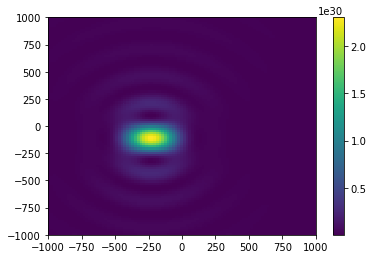

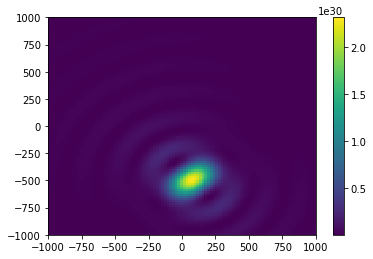

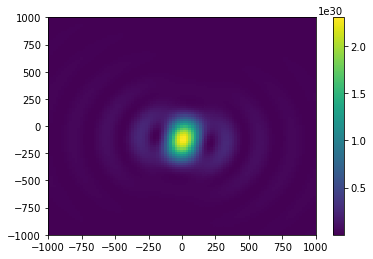

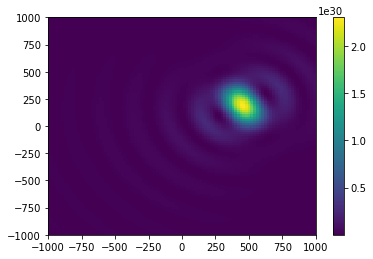

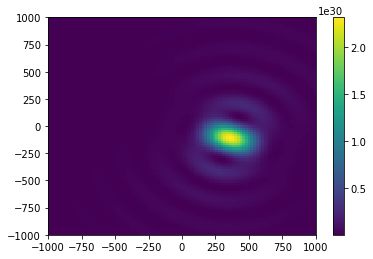

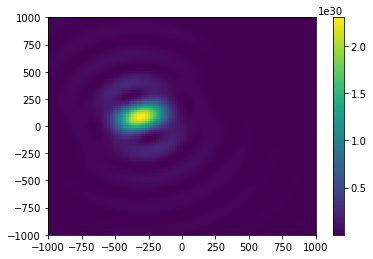

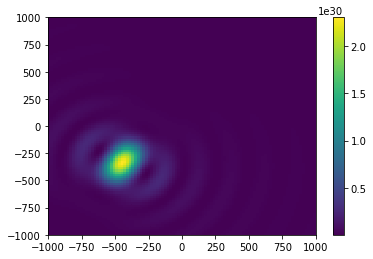

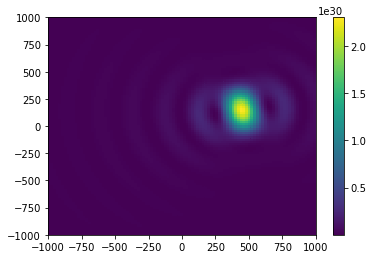

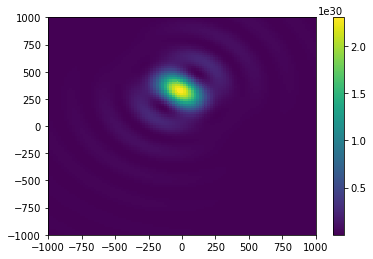

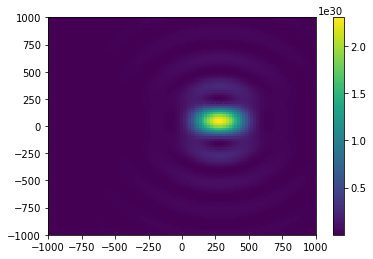

In [6]:
# define angles
number_of_molecules = 10
ordered_angles = np.linspace(0,2*np.pi,number_of_molecules)
print('ordered_angles.shape',ordered_angles.shape)

# define cartesien components of pipole unit vector
ordered_dipole_unit_array = make_in_plane_cartesien_angles_array(ordered_angles)
print('ordered_dipole_unit_array.shape',ordered_dipole_unit_array.shape)

# Calcualte p0 from coupled equations of motion
ordered_p0_array = define_p_test_array(ordered_dipole_unit_array)
print('ordered_p0_array.shape',ordered_p0_array.shape)

# Calculate fields from dipole moment array
ord_E = mb_p_fields(ordered_p0_array, place_molecules_in_plane(number_of_molecules))
print('ord_E.shape',ord_E.shape)

for i in np.arange(number_of_molecules):
    plt.figure()
    plt.pcolor(
        eye[1]*1e7,
        eye[2]*1e7,
        (np.abs(ord_E[0,i])**2.+np.abs(ord_E[1,i])**2.+np.abs(ord_E[2,i])**2.).reshape(eye[1].shape)
        )
    plt.colorbar()

random_angles.shape (10,)
ordered_dipole_unit_array.shape (10, 3)
ordered_p0_array.shape (10, 3)
inside anal_foc_diff_fields.E_field, 
 xi.shape =  (10, 10000) 
 y.shape =  (10, 10000) k =  131659.645116
inside anal_foc_diff_fields.E_field, 
 xi.shape =  (10, 10000) 
 y.shape =  (10, 10000) k =  131659.645116
ord_E.shape (3, 10, 10000)


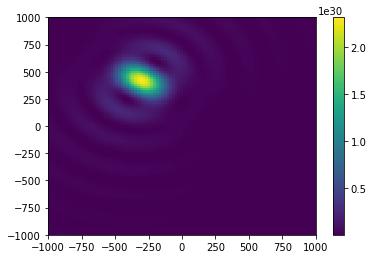

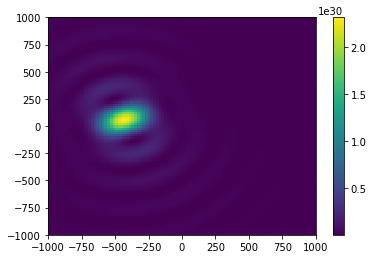

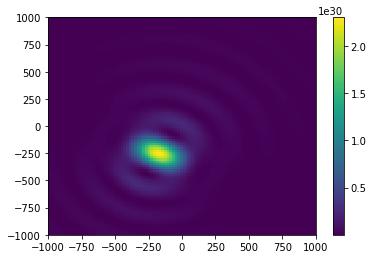

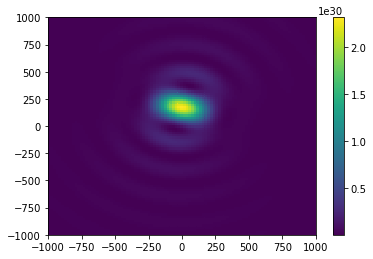

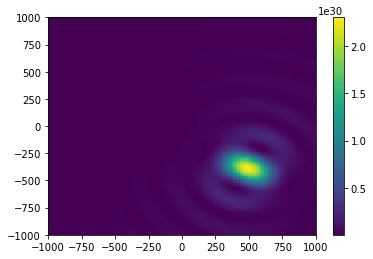

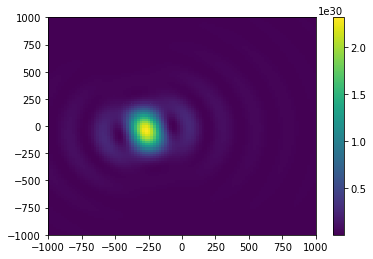

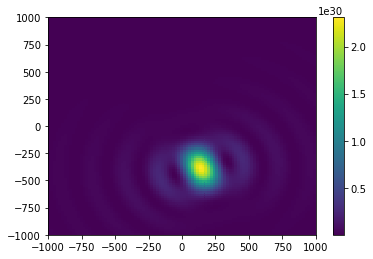

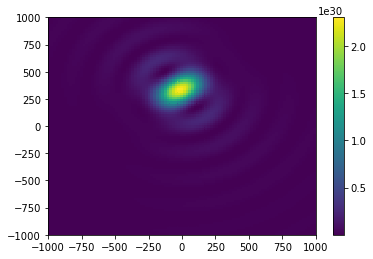

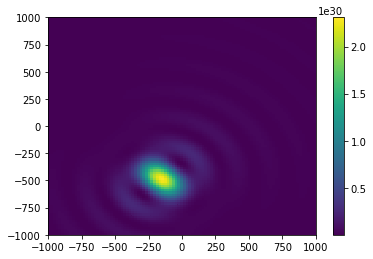

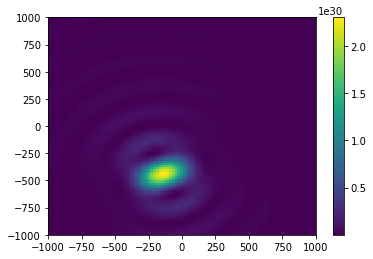

In [7]:
# define angles
number_of_molecules = 10
random_angles = np.random.random_sample(number_of_molecules)*2*np.pi
print('random_angles.shape',random_angles.shape)

# define cartesien components of pipole unit vector
ordered_dipole_unit_array = make_in_plane_cartesien_angles_array(random_angles)
print('ordered_dipole_unit_array.shape',ordered_dipole_unit_array.shape)

# Calcualte p0 from coupled equations of motion
ordered_p0_array = define_p_test_array(ordered_dipole_unit_array)
print('ordered_p0_array.shape',ordered_p0_array.shape)

# Calculate fields from dipole moment array
ord_E = mb_p_fields(ordered_p0_array, place_molecules_in_plane(number_of_molecules))
print('ord_E.shape',ord_E.shape)

for i in np.arange(number_of_molecules):
    plt.figure()
    plt.pcolor(
        eye[1]*1e7,
        eye[2]*1e7,
        (np.abs(ord_E[0,i])**2.+np.abs(ord_E[1,i])**2.+np.abs(ord_E[2,i])**2.).reshape(eye[1].shape)
        )
    plt.colorbar()

In [8]:


def make_fields(
    number_of_molecules = 100.,
    dx = 150.
    #plas_orientation=[0,1,0] #pi
    ):

    molecule_locations_in_plane=(np.array([[1,0]])*np.ones((number_of_molecules,2))*dx*nm)
    molecule_angles=np.random.random_sample(number_of_molecules)*2*np.pi
    
    p0_hat = make_in_plane_cartesien_angles_array(molecule_angles)

    bf_x0 = molecule_locations_in_plane
    print("bf_x0.shape",bf_x0.shape)
    bf_p0 = define_p_test_array(p0_hat)

    
    E0 = mb_p_fields(bf_p0, bf_x0)
    print("E0.shape",E0.shape)
    return E0
        
def fields_to_hist(field_array):
    E0 = field_array
    E1 = np.zeros(E0.shape)
    
    mol_images = (np.abs(E0[0])**2.+np.abs(E0[1])**2.+np.abs(E0[2])**2.)
    plas_images = (np.abs(E1[0])**2.+np.abs(E1[1])**2.+np.abs(E1[2])**2.)
    images = (
        np.abs(E1[0]+E0[0])**2.
        +
        np.abs(E1[1]+E0[1])**2.
        +
        np.abs(E1[2]+E0[2])**2.
        )



    Ix = np.abs(E1[0]+E0[0])**2.    
    Iy = np.abs(E1[1]+E0[1])**2.    

    Px = np.sum(Ix,axis=-1)
    Py = np.sum(Iy,axis=-1)

    normed_Px = Px - np.min(Px)*.99
    normed_Py = Py - np.min(Py)*.99

    observed_angles = np.arctan(normed_Py**0.5/normed_Px**0.5)
#     print(observed_angles)
    plt.figure()
    plt.hist(observed_angles,25)
    ticks = [0,np.pi/4,np.pi/2]
    tick_labels = [0, r'$\pi/4$',r'$\pi/2$']
    plt.xticks(ticks, tick_labels)
#     plt.yticks([0,np.pi/16,np.pi/8,np.pi/4,3*np.pi/8,np.pi/2], 
#               [r'$0$', r'$\pi/16$',r'$\pi/8$',r'$\pi/4$',r'$3\pi/8$',r'$\pi/2$'])
    plt.ylabel('molecule images')
    plt.xlabel('actual angle')
#     if np.all(plas_orientation==[1,0,0]):
#         plas_unit_sym = r'\hat{x}'
#     elif np.all(plas_orientation==[0,1,0]):
#         plas_unit_sym = r'$\hat{y}$'
#     else: plas_unit_sym = '{}'.format(plas_orientation)
#     plt.title('d = {0} nm, '.format(dnm)+r'$\hat{p}_\mathrm{plas} = $'+plas_unit_sym)
    plt.show()
    return None

/Users/chair/anaconda/envs/py27/lib/python2.7/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
/Users/chair/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


bf_x0.shape (100, 2)
inside anal_foc_diff_fields.E_field, 
 xi.shape =  (100, 10000) 
 y.shape =  (100, 10000) k =  131659.645116
inside anal_foc_diff_fields.E_field, 
 xi.shape =  (100, 10000) 
 y.shape =  (100, 10000) k =  131659.645116
E0.shape (3, 100, 10000)


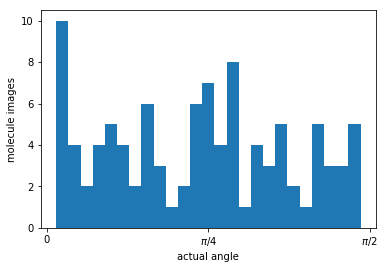

In [9]:
fields_to_hist(make_fields())

In [ ]:
def make_fields(
    number_of_molecules = 100.,
    dx = 150.
    #plas_orientation=[0,1,0] #pi
    ):

    molecule_locations_in_plane=(np.array([[1,0]])*np.ones((number_of_molecules,2))*dx*nm)
    molecule_angles=np.random.random_sample(number_of_molecules)*2*np.pi
    
    p0_hat = make_in_plane_cartesien_angles_array(molecule_angles)

    bf_x0 = molecule_locations_in_plane
    print("bf_x0.shape",bf_x0.shape)
    bf_p0 = define_p_test_array(p0_hat)

    
    E0 = mb_p_fields(bf_p0, bf_x0)
    print("E0.shape",E0.shape)
    return E0
        
def fields_to_hist(field_array,bins=50):
    E0 = field_array
    E1 = np.zeros(E0.shape)
    
    mol_images = (np.abs(E0[0])**2.+np.abs(E0[1])**2.+np.abs(E0[2])**2.)
    plas_images = (np.abs(E1[0])**2.+np.abs(E1[1])**2.+np.abs(E1[2])**2.)
    images = (
        np.abs(E1[0]+E0[0])**2.
        +
        np.abs(E1[1]+E0[1])**2.
        +
        np.abs(E1[2]+E0[2])**2.
        )



    Ix = np.abs(E1[0]+E0[0])**2.    
    Iy = np.abs(E1[1]+E0[1])**2.    

    Px = np.sum(Ix,axis=-1)
    Py = np.sum(Iy,axis=-1)

    normed_Px = Px - np.min(Px)
    normed_Py = Py - np.min(Py)

    observed_angles = np.arctan(normed_Py**0.5/normed_Px**0.5)
#     print(observed_angles)
    plt.figure()
    plt.hist(observed_angles,bins)
    ticks = [0,np.pi/4,np.pi/2]
    tick_labels = [0, r'$\pi/4$',r'$\pi/2$']
    plt.xticks(ticks, tick_labels)
#     plt.yticks([0,np.pi/16,np.pi/8,np.pi/4,3*np.pi/8,np.pi/2], 
#               [r'$0$', r'$\pi/16$',r'$\pi/8$',r'$\pi/4$',r'$3\pi/8$',r'$\pi/2$'])
    plt.ylabel('molecule images')
    plt.xlabel('actual angle')
#     if np.all(plas_orientation==[1,0,0]):
#         plas_unit_sym = r'\hat{x}'
#     elif np.all(plas_orientation==[0,1,0]):
#         plas_unit_sym = r'$\hat{y}$'
#     else: plas_unit_sym = '{}'.format(plas_orientation)
#     plt.title('d = {0} nm, '.format(dnm)+r'$\hat{p}_\mathrm{plas} = $'+plas_unit_sym)
    plt.show()
    return observed_angles

bf_x0.shape (100, 2)
inside anal_foc_diff_fields.E_field, 
 xi.shape =  (100, 10000) 
 y.shape =  (100, 10000) k =  131659.645116
inside anal_foc_diff_fields.E_field, 
 xi.shape =  (100, 10000) 
 y.shape =  (100, 10000) k =  131659.645116
E0.shape (3, 100, 10000)


/Users/chair/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:46: RuntimeWarning: divide by zero encountered in true_divide


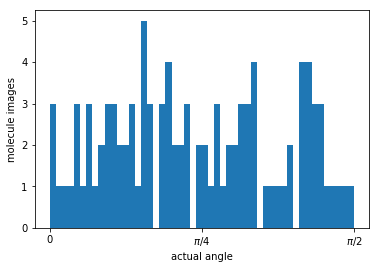

array([ 0.26087816,  0.93527171,  0.68183711,  0.22108382,  0.4637243 ,
        0.59684092,  0.02106249,  0.91604347,  0.57537656,  1.35513056,
        1.03216455,  0.78573087,  1.32769806,  0.61318193,  1.10949018,
        0.14602027,  0.03101252,  0.69547048,  0.19915163,  1.00338054,
        1.29043782,  0.41822909,  0.49387592,  0.99995519,  0.67957367,
        0.86426296,  1.0456282 ,  0.13974821,  0.62120456,  1.00909997,
        0.09073916,  1.30237789,  0.88928204,  1.40979356,  0.33660067,
        0.28288441,  1.30567396,  1.19372426,  1.36980249,  0.8282587 ,
        0.86844033,  1.32769025,  0.26813813,  0.50263544,  0.31834895,
        1.15139374,  1.04716035,  0.95239699,  0.95818088,  0.36485291,
        0.28741004,  0.99682563,  1.52600739,  0.11185119,  1.03098821,
        1.21443969,  0.51533215,  0.31959389,  0.65084946,  0.41941258,
        0.48761068,  0.60012975,  0.28514958,  0.20922138,  1.30449715,
        0.71383955,  1.42490121,  0.        ,  0.04764281,  1.24

In [13]:
fields_to_hist(make_fields(number_of_molecules=100))

In [ ]:
fields_to_hist(make_fields(number_of_molecules=100,dx=1))

In [15]:
fields_to_hist(make_fields(number_of_molecules=1000,dx=1),bins=50)

bf_x0.shape (1000, 2)
inside anal_foc_diff_fields.E_field, 
 xi.shape =  (1000, 10000) 
 y.shape =  (1000, 10000) k =  131659.645116
inside anal_foc_diff_fields.E_field, 
 xi.shape =  (1000, 10000) 
 y.shape =  (1000, 10000) k =  131659.645116


KeyboardInterrupt: 

In [16]:
more_datas = fields_to_hist(make_fields(number_of_molecules=1000,dx=1),bins=50)

bf_x0.shape (1000, 2)
inside anal_foc_diff_fields.E_field, 
 xi.shape =  (1000, 10000) 
 y.shape =  (1000, 10000) k =  131659.645116


KeyboardInterrupt: 

In [ ]:
def fields_to_mol_map(
    number_of_molecules = 100.,
    dx = 150.
    #plas_orientation=[0,1,0] #pi
    ):

    molecule_locations_in_plane=(np.array([[1,0]])*np.ones((number_of_molecules,2))*dx*nm)
    molecule_angles=np.linspace(0,2*np.pi,number_of_molecules)
    
    p0_hat = make_in_plane_cartesien_angles_array(molecule_angles)

    bf_x0 = molecule_locations_in_plane
    print("bf_x0.shape",bf_x0.shape)
    bf_p0 = define_p_test_array(p0_hat)

    
    E0 = mb_p_fields(bf_p0, bf_x0)
#     print("E0.shape",E0.shape)
#     return E0

# field_array):
    mol_E = E0
#     E1 = field_array[1]
    
    Ix = np.abs(mol_E[0])**2.    
    Iy = np.abs(mol_E[1])**2.    

    Px = np.sum(Ix,axis=-1)
    Py = np.sum(Iy,axis=-1)

    normed_Px = Px - np.min(Px)
    normed_Py = Py - np.min(Py)
    
    ordered_angles = np.linspace(0,2*np.pi,number_of_molecules)
    observed_angles = np.arctan(normed_Py**0.5/normed_Px**0.5)
    
    plt.figure()
    plt.plot(ordered_angles,observed_angles)
    ticks = [0,np.pi/4,np.pi/2,3*np.pi/4,np.pi, 2*np.pi]
    tick_labels = [0, r'$\pi/4$',r'$\pi/2$',r'$3\pi/4$', r'$\pi$',r'$2\pi$']
    plt.xticks(ticks, tick_labels)
    plt.yticks([0,np.pi/16,np.pi/8,np.pi/4,3*np.pi/8,np.pi/2], 
              [r'$0$', r'$\pi/16$',r'$\pi/8$',r'$\pi/4$',r'$3\pi/8$',r'$\pi/2$'])
    plt.ylabel('observed angle')
    plt.xlabel('actual angle')
    plt.show()

bf_x0.shape (100, 2)
inside anal_foc_diff_fields.E_field, 
 xi.shape =  (100, 10000) 
 y.shape =  (100, 10000) k =  131659.645116
inside anal_foc_diff_fields.E_field, 
 xi.shape =  (100, 10000) 
 y.shape =  (100, 10000) k =  131659.645116


/Users/chair/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:35: RuntimeWarning: divide by zero encountered in true_divide


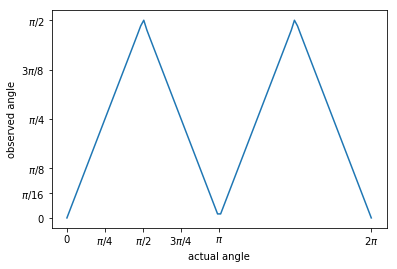

In [20]:
fields_to_mol_map(number_of_molecules=100)

bf_x0.shape (1000, 2)
inside anal_foc_diff_fields.E_field, 
 xi.shape =  (1000, 10000) 
 y.shape =  (1000, 10000) k =  131659.645116
inside anal_foc_diff_fields.E_field, 
 xi.shape =  (1000, 10000) 
 y.shape =  (1000, 10000) k =  131659.645116


/Users/chair/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:35: RuntimeWarning: divide by zero encountered in true_divide


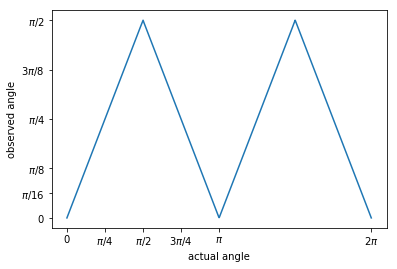

In [21]:
fields_to_mol_map(number_of_molecules=1000)

No more subtracting after talking to Curly on 09/27/18

In [22]:
def fields_to_mol_map_raw(
    number_of_molecules = 100.,
    dx = 150.
    #plas_orientation=[0,1,0] #pi
    ):

    molecule_locations_in_plane=(np.array([[1,0]])*np.ones((number_of_molecules,2))*dx*nm)
    molecule_angles=np.linspace(0,2*np.pi,number_of_molecules)
    
    p0_hat = make_in_plane_cartesien_angles_array(molecule_angles)

    bf_x0 = molecule_locations_in_plane
    print("bf_x0.shape",bf_x0.shape)
    bf_p0 = define_p_test_array(p0_hat)

    
    E0 = mb_p_fields(bf_p0, bf_x0)
#     print("E0.shape",E0.shape)
#     return E0

# field_array):
    mol_E = E0
#     E1 = field_array[1]
    
    Ix = np.abs(mol_E[0])**2.    
    Iy = np.abs(mol_E[1])**2.    

    Px = np.sum(Ix,axis=-1)
    Py = np.sum(Iy,axis=-1)

#     normed_Px = Px - np.min(Px)
#     normed_Py = Py - np.min(Py)
    
    ordered_angles = np.linspace(0,2*np.pi,number_of_molecules)
    observed_angles = np.arctan(Py**0.5/Px**0.5)
#     plt.plot(ordered_angles,Py**0.5/Px**0.5)
    
    plt.figure()
    the_plot = plt.plot(ordered_angles,observed_angles)
    ticks = [0,np.pi/4,np.pi/2,3*np.pi/4,np.pi, 2*np.pi]
    tick_labels = [0, r'$\pi/4$',r'$\pi/2$',r'$3\pi/4$', r'$\pi$',r'$2\pi$']
    plt.xticks(ticks, tick_labels)
    plt.yticks([0,np.pi/16,np.pi/8,np.pi/4,3*np.pi/8,np.pi/2], 
              [r'$0$', r'$\pi/16$',r'$\pi/8$',r'$\pi/4$',r'$3\pi/8$',r'$\pi/2$'])
    plt.ylabel('observed angle')
    plt.xlabel('actual angle')
#     plt.savefig('obs_pol_to_angoe_map.', )
    
    return [ordered_angles,observed_angles]

bf_x0.shape (1000, 2)
inside anal_foc_diff_fields.E_field, 
 xi.shape =  (1000, 10000) 
 y.shape =  (1000, 10000) k =  131659.645116
inside anal_foc_diff_fields.E_field, 
 xi.shape =  (1000, 10000) 
 y.shape =  (1000, 10000) k =  131659.645116


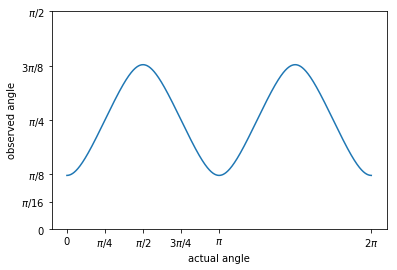

In [31]:
unsubbed_ordered_angles,unsubbed_observed_angles = fields_to_mol_map_raw(number_of_molecules=1000)


In [32]:
np.min(unsubbed_observed_angles)

0.38569470361840247

In [24]:
save_data = np.ones((unsubbed_ordered_angles.shape[0],2))
save_data[:,0] = unsubbed_ordered_angles
save_data[:,1] = unsubbed_observed_angles
np.savetxt('obs_pol_vs_true_angle.txt',save_data)


In [25]:
from scipy import interpolate

In [26]:
np.int(unsubbed_observed_angles.shape[0]/4)

250

In [27]:
unsubbed_ordered_angles[:np.int(unsubbed_observed_angles.shape[0]/4+1)]

array([ 0.        ,  0.00628947,  0.01257895,  0.01886842,  0.0251579 ,
        0.03144737,  0.03773685,  0.04402632,  0.0503158 ,  0.05660527,
        0.06289475,  0.06918422,  0.0754737 ,  0.08176317,  0.08805265,
        0.09434212,  0.1006316 ,  0.10692107,  0.11321055,  0.11950002,
        0.1257895 ,  0.13207897,  0.13836845,  0.14465792,  0.15094739,
        0.15723687,  0.16352634,  0.16981582,  0.17610529,  0.18239477,
        0.18868424,  0.19497372,  0.20126319,  0.20755267,  0.21384214,
        0.22013162,  0.22642109,  0.23271057,  0.23900004,  0.24528952,
        0.25157899,  0.25786847,  0.26415794,  0.27044742,  0.27673689,
        0.28302637,  0.28931584,  0.29560531,  0.30189479,  0.30818426,
        0.31447374,  0.32076321,  0.32705269,  0.33334216,  0.33963164,
        0.34592111,  0.35221059,  0.35850006,  0.36478954,  0.37107901,
        0.37736849,  0.38365796,  0.38994744,  0.39623691,  0.40252639,
        0.40881586,  0.41510534,  0.42139481,  0.42768429,  0.43

In [28]:
np.pi/2

1.5707963267948966

In [29]:
f = interpolate.interp1d(unsubbed_ordered_angles,unsubbed_observed_angles)
f_inv = interpolate.interp1d(
    unsubbed_observed_angles[:np.int(unsubbed_observed_angles.shape[0]/4)],
    unsubbed_ordered_angles[:np.int(unsubbed_observed_angles.shape[0]/4)])

In [30]:
f_inv(0)

ValueError: A value in x_new is below the interpolation range.

In [ ]:
plt.plot(f_inv(np.linspace(0.39,3*np.pi/8,100)))

In [ ]:
np.min(f_inv(np.linspace(0.3857,3*np.pi/8,100)))

In [ ]:
plt.plot(np.linspace(0,np.pi/2,1000),f(np.linspace(0,np.pi/2,1000)))
plt.xticks([0,np.pi/8,np.pi/4,3*np.pi/8,np.pi/2], [0,r'$\pi/8$',r'$\pi/4$',r'$3\pi/8$',r'$\pi/2$'])

In [ ]:
np.save('interpolant.pkl',f_inv)

In [ ]:
f_inv

In [ ]:
f_inv(0)